<a href="https://colab.research.google.com/github/sartaj-sb/Tensors/blob/main/edge_impulse_raw_image_uploader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random, os, PIL, json, time, hmac, hashlib, requests, threading, queue

from skimage.transform import resize                      # Used to scale/resize image arrays


In [ ]:
### Settings

# Edge Impulse > your_project > Dashboard > Keys
EI_API_KEY = "ei_8f1797e02427648310d08ce2eb6bc98935e50fdf1fdb96e3d27dc970163ab1e4"
EI_HMAC_KEY = "1b42941aa5c0303d00d5088abaf636ec"

# Number of threads to run to upload data to Edge Impulse
NUM_THREADS = 20

# Location of dataset
DATASET_PATH = "/content/dataset"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for test set (Edge Impulse automatically extracts validation set during training)
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)


Curate Image Dataset

The following cells perform the following:

    Load images from filesystem as grayscale values
    Set aside some portion of the dataset as test data
    Resize images
    Normalize pixel value from [0, 255] to [0.0, 1.0]
    Flatten images to 1D array



In [ ]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground truth labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
  class_dir = os.path.join(DATASET_PATH, label)
  if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
    labels.append(label)

    # Go through each image in the folder
    for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
      if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
        file_path = os.path.join(class_dir, file)
        img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
        img_array = np.asarray(img)
        if INVERT:
          img_array = 255 - img_array
        X_all.append(img_array)

        # Add label to the y array
        y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from pin
Added 51 images from background
Added 50 images from sdcard
Added 50 images from bud
['background', 'bud', 'pin', 'sdcard']
Number of samples: 201


In [ ]:
### Shuffle samples and labels together, divide into test and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The remaining samples become the training set
X_train = X_all[num_samples_test:]
y_train = y_all[num_samples_test:]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test and training samples
print("Number of test samples:", num_samples_test)
print("Number of training samples:", num_samples_train)

Number of test samples: 40
Number of training samples: 161


Label: bud
[[200 199 196 ... 183 183 183]
 [200 198 197 ... 183 183 183]
 [198 198 198 ... 184 183 184]
 ...
 [201 200 201 ... 178 178 178]
 [200 200 200 ... 178 178 178]
 [199 199 199 ... 179 178 178]]


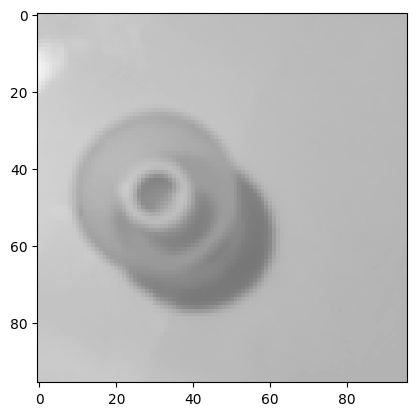

In [ ]:
### View one of the training samples

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + y_train[idx])
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [ ]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
  """
  Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
  width. Returns the list of newly resized image arrays.

  NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
  """
  X_out = []
  for i, img in enumerate(images):
    X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
  return X_out

In [ ]:


### Scale/crop images (Note: also normalizes data to 0..1)

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)



Label: bud
First row: [[0.77622963 0.77474772 0.77151724 0.77667791 0.78550851 0.78596771
  0.78272886 0.77679404 0.76732517 0.75579464 0.74877817 0.7486584
  0.74758604 0.74416956 0.7405392  0.73810008 0.73690296 0.73445115
  0.73146802 0.72933106 0.72601907 0.72596668 0.72418255 0.7236934
  0.72271025 0.72205054 0.72112349 0.71894495]]


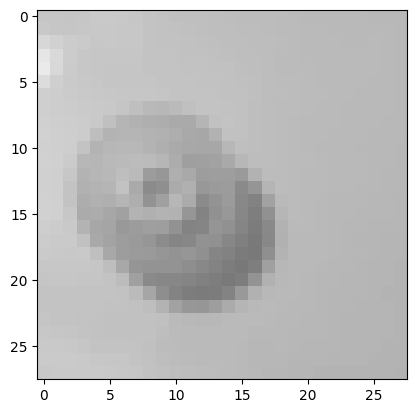

In [ ]:


### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + y_train[idx])
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)



In [ ]:


### Convert list of samples into Numpy arrays

# Convert sets
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Test X:", X_test.shape)



Training X: (161, 28, 28)
Test X: (40, 28, 28)


In [ ]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that we will flatten each image to
len_vector = TARGET_WIDTH * TARGET_WIDTH

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Test X:", X_test.shape)

Training X: (161, 784)
Test X: (40, 784)


In [ ]:


def create_json_wrapper():
  """
  Construct initial JSON wrapper as a template
  """

  # Start with all zeros. Hs256 gives 32 bytes and we encode in hex. So, we need 64 characters here.
  empty_signature = ''.join(['0'] * 64)

  # Create JSON wrapper for data
  data = {
      "protected": {
          "ver": "v1",
          "alg": "HS256",
          "iat": time.time()                  # Epoch time, seconds since 1970
      },
      "signature": empty_signature,
      "payload": {
          "device_type": "pre-made",          # Pre-made dataset (not collected)
          "interval_ms": 1,                   # Pretend it's interval of 1 ms
          "sensors": [
              { "name": "img", "units": "B" } # Unitless ("Byte" data)
          ],
          "values": []
      }
  }

  return data



In [ ]:
def send_sample(data, label, test_set=False):
  """
  Send raw data sample to Edge Impulse project, return HTTP status code
  """

  # Encode message in JSON format
  encoded = json.dumps(data)

  # Sign message
  signature = hmac.new(bytes(EI_HMAC_KEY, 'utf-8'),
                      msg = encoded.encode('utf-8'),
                      digestmod = hashlib.sha256).hexdigest()

  # Set the signature in the message and encode data again to JSON format
  data['signature'] = signature
  encoded = json.dumps(data)

  # Construct URL based on dataset being sent
  if test_set:
    url = 'https://ingestion.edgeimpulse.com/api/testing/data'
  else:
    url = 'https://ingestion.edgeimpulse.com/api/training/data'

  # Upload the data to project
  res = requests.post(url=url,
                      data=encoded,
                      headers={
                          'Content-Type': 'application/json',
                          'x-file-name': str(label),
                          'x-api-key': EI_API_KEY
                      })

  return res


In [ ]:
def upload_sample(len_vector, is_test_set):
  """
  Pull sample and label from queue and send to Edge Impulse server. To be called within a thread.
  """

  global q

  while not q.empty():

    # Start with empty JSON wrapper
    data = create_json_wrapper()

    # Fill up values field (we need to convert to float to avoid JSON error)
    sample, label = q.get()
    for j in range(len_vector):
      data['payload']['values'].append(float(sample[j]))

    # Send sample
    res = send_sample(data, label, test_set=is_test_set)

    # Check response code
    if (res.status_code != 200):
      print("Failed to upload file to Edge Impulse", res.status_code, res.content)


In [ ]:
### Use many threads to send training data and labels to Edge Impulse project

# Fill queue with training data and labels
q = queue.Queue()
for i in range(num_samples_train):
  q.put((X_train[i], y_train[i]))

# Create and start threads
threads = []
for i in range(NUM_THREADS):
  threads.append(threading.Thread(target=upload_sample, args=(len_vector, False)))
  threads[i].start()

# Wait for threads to be done
for thread in threads:
  thread.join()

In [ ]:


### Use many threads to send test data and labels to Edge Impulse project

# Fill queue with test data and labels
q = queue.Queue()
for i in range(num_samples_test):
  q.put((X_test[i], y_test[i]))

# Create and start threads
threads = []
for i in range(NUM_THREADS):
  threads.append(threading.Thread(target=upload_sample, args=(len_vector, True)))
  threads[i].start()

# Wait for threads to be done
for thread in threads:
  thread.join()

